In [1]:
import sys
import os
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re

import src.io as sio
import src.qudi_fit_wrapper as qft
import src.helpers as shp
import src.fitting as sft

plt.style.use('seaborn')

src.fit_logic :: INFO :: Methods were included to FitLogic, but only if naming is right: check the doxygen documentation if you added a new method and it does not show.


In [2]:
DATA_FOLDER = "20220112_SingleNV_Membrane_RT"
DATA_FOLDERPATH, FIGURE_FOLDERPATH = sio.get_data_and_figure_paths(DATA_FOLDER)

src.io :: INFO :: qudiamond folderpath is \\kernix\qudiamond\Data\20220112_SingleNV_Membrane_RT\


# Counter

In [ ]:
counter_filepaths, counter_filenames = sio.get_measurement_file_list(DATA_FOLDERPATH, measurement="Counter")

In [ ]:
counter_filenames

## Unstable counts

In [ ]:
to_plot = ["20220117-1718-21_count_trace_NV8_during_odmr"]

fig, ax = plt.subplots(nrows=len(to_plot), figsize=(5, 2))

idx = 0
for filepath, filename in zip(counter_filepaths, counter_filenames):
    for f in to_plot:
        if f in filename:
            df = sio.read_into_df(filepath)
            x = df["Time (s)"]
            y = df["Signal0 (counts/s)"] / 1e3
            ax.plot(x, y)
            #ax[idx].set_ylabel("Counts (kcps)")
            idx += 1

ax.set_xlabel("Time (s)")
fig.text(0.0, 0.5, 'Counts (kcps)', va='center', rotation='vertical')
fig.tight_layout()
# sio.save_figures("timetrace_measurement_falling", folder=FIGURE_FOLDERPATH)

In [ ]:
to_plot = ["20220114-1451-24_count_trace_NV10", "20220203-1427-15_count_trace_NV2", "20220114-1719-46_count_trace_NV14", "20220117-1718-21_count_trace_NV8_during_odmr"]

fig, ax = plt.subplots(nrows=len(to_plot), sharex=True)

idx = 0
for filepath, filename in zip(counter_filepaths, counter_filenames):
    for f in to_plot:
        if f in filename:
            df = sio.read_into_df(filepath)
            x = df["Time (s)"]
            y = df["Signal0 (counts/s)"] / 1e3
            ax[idx].plot(x, y)
            #ax[idx].set_ylabel("Counts (kcps)")
            idx += 1

ax[-1].set_xlabel("Time (s)")
fig.text(0.04, 0.5, 'Counts (kcps)', va='center', rotation='vertical')
# sio.save_figures("timetrace_comparison_falling", folder=FIGURE_FOLDERPATH)

## Stable counts

In [ ]:
to_plot = ["20220113-1139-58_count_trace_NV0", "20220113-1411-33_count_trace_NV3", "20220113-1438-24_count_trace_NV5", "20220126-1350-50_count_trace_NV1"]

fig, ax = plt.subplots(nrows=len(to_plot), sharex=True)

idx = 0
for filepath, filename in zip(counter_filepaths, counter_filenames):
    for f in to_plot:
        if f in filename:
            df = sio.read_into_df(filepath)
            x = df["Time (s)"]
            y = df["Signal0 (counts/s)"] / 1e3
            ax[idx].plot(x, y)
            idx += 1

ax[-1].set_xlabel("Time (s)")
fig.text(0.04, 0.5, 'Counts (kcps)', va='center', rotation='vertical')
sio.save_figures("timetrace_comparison_stable", folder=FIGURE_FOLDERPATH)

## Plot all

In [ ]:
%%capture

for filepath, filename in zip(counter_filepaths, counter_filenames):
    fig, ax = plt.subplots()

    df = sio.read_into_df(filepath)
    x = df["Time (s)"]
    y = df["Signal0 (counts/s)"] / 1e3
    ax.plot(x, y)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Counts (kcps)")
    sio.save_figures(filename, folder=os.path.join(FIGURE_FOLDERPATH, "counters"), only_jpg=True)
    plt.close()

# Confocal

In [ ]:
confocal_filepaths, confocal_filenames = sio.get_measurement_file_list(DATA_FOLDERPATH, measurement="Confocal")

In [ ]:
confocal_filepaths

## Plot all

In [ ]:
%%capture

for filepath, filename in zip(confocal_filepaths, confocal_filenames):
    if "image" in filename:
        params = sio.read_qudi_parameters(filepath)
        data = np.genfromtxt(filepath, dtype=None, delimiter='\t')
        extent = np.array([params['X image min (m)'], params['X image max (m)'], params['Y image min'], params['Y image max']]) * 1e6
        fig, ax = plt.subplots()
        img = ax.imshow(data/1e3, cmap="magma", origin="lower", extent=extent)
        cbar = fig.colorbar(img, ax=ax)
        cbar.set_label("Fluorescence (kc/s)")
        ax.set_xlabel("X (μm)")
        ax.set_ylabel("Y (μm)")
        ax.grid(False)
        sio.save_figures(filename, folder=os.path.join(FIGURE_FOLDERPATH, "confocals"), only_jpg=True)
        plt.close()

# Plot relevant

In [ ]:
%matplotlib widget

to_plot = ["20220131-1236-00_upper_right_label_confocal_xy_image_1" , "20220113-1011-19__confocal_xy_image_1", "20220131-1249-56_upper_left_label_confocal_xy_image_1"]

for filepath, filename in zip(confocal_filepaths, confocal_filenames):
    for f in to_plot:
        if f in filename:
            params = sio.read_qudi_parameters(filepath)
            data = np.genfromtxt(filepath, dtype=None, delimiter='\t')

            extent = np.array([params['X image min (m)'], params['X image max (m)'], params['Y image min'], params['Y image max']]) * 1e6
            fig, ax = plt.subplots()
            img = ax.imshow(data/1e3, cmap=sns.color_palette("mako", as_cmap=True), vmin=1, vmax=80, origin="lower", extent=extent)
            cbar = fig.colorbar(img, ax=ax)
            cbar.set_label("Fluorescence (kc/s)")
            ax.set_xlabel("X (μm)")
            ax.set_ylabel("Y (μm)")
            ax.grid(False)
            sio.save_figures(filename, folder=FIGURE_FOLDERPATH)

# Autocorrelation

In [ ]:
autocorr_filepaths, autocorr_filenames = sio.get_measurement_file_list(DATA_FOLDERPATH, measurement="Autocorrelation")

In [ ]:
autocorr_filenames

In [ ]:
fig, ax = plt.subplots(figsize=(5, 4))

to_plot = ["20220126-1350-55", "20220131-1046-57"]

for filepath, filename in zip(autocorr_filepaths, autocorr_filenames):
    for p in to_plot:
        if p in filename:
            if p == "20220126-1350-55":
                label = "Single NV"
                color = "C0"
            else:
                label = "Double NV"
                color = "C2"
            df = sio.read_into_df(filepath)
            x = df["Time (ps)"] / 1e3
            y = df["g2(t) norm"]
            fit = sft.autocorrelation_fit(x, y)
            ax.plot(x, y, ".", label=label, color=color)
            ax.plot(x, fit["fit"], linewidth=2, color=color)
            
ax.axhspan(0, 0.5, alpha=0.3, color="C1")

ax.legend()
ax.set_xlabel(r"$\tau$ (ns)")
ax.set_ylabel(r"g$^{(2)} (\tau)$")
fig.tight_layout()

sio.save_figures("autocorr_comparison", FIGURE_FOLDERPATH)

# pODMR

In [ ]:
pulsed_odmr_data = sio.read_pulsed_odmr_data(DATA_FOLDERPATH)

In [ ]:
pulsed_odmr_data.keys()

In [ ]:
%%capture
pulsed_odmr_data1 = pulsed_odmr_data.copy()

keys_to_remove = ["20220117-1718-30",  '20220119-1546-54', '20220126-1454-43', '20220126-1630-37', '20220126-1641-37', '20220126-1649-29', '20220128-1607-05', '20220131-1018-39']
list(map(pulsed_odmr_data1.pop, keys_to_remove))

In [ ]:
fig, (ax, ax1, ax2) = plt.subplots(nrows=3, figsize=(7, 6), sharex=True)

key = '20220126-1653-18'
df = pulsed_odmr_data1[key]["measurement"]["data"]
params = pulsed_odmr_data1[key]["measurement"]["params"]
power = params["Microwave Sweep Power (dBm)"]

x = df["frequency (Hz)"] / 1e9
y =  df["count data (counts/s)"] / df["count data (counts/s)"].max()
ax.plot(x, y, ".")
fit_x, fit_y, result = qft.perform_fit(x, y, "lorentzian", estimator="dip")
ax.plot(fit_x, fit_y, label=f"{power} dBm")
ax.axvline(result.params["center"].value, linestyle="--")
ax.set_title(f"Center = {result.params['center'].value:.3f} GHz, Contrast = {abs(result.params['amplitude'].value) * 1e2:.1f}%")
ax.set_ylabel(r"$P (m_s = 0)$")


key = '20220128-1428-10'
df = pulsed_odmr_data1[key]["measurement"]["data"]
params = pulsed_odmr_data1[key]["measurement"]["params"]
power = params["Microwave Sweep Power (dBm)"]

x = df["frequency (Hz)"] / 1e9
y =  df["count data (counts/s)"] / df["count data (counts/s)"].max()
ax1.plot(x, y, ".")
fit_x, fit_y, result = qft.perform_fit(x, y, "lorentziandouble", estimator="dip")
ax1.plot(fit_x, fit_y, label=f"{power} dBm")
delta_e = (result.params["l1_center"].value - result.params["l0_center"].value)
b_field = delta_e / (2 * 2.8) * 1e3
ax1.set_title(r"With magnetic field, ($\Delta E \approx$" + f"{delta_e:.2f} GHz" +  r"$ \rightarrow |B| \approx$" + f"{b_field:.1f} mT)")
ax1.axvline(result.params["l0_center"].value, linestyle="--")
ax1.axvline(result.params["l1_center"].value, linestyle="--")
ax1.set_ylabel(r"$P (m_s = 0)$")


key = '20220203-1426-03'
df = pulsed_odmr_data1[key]["measurement"]["data"]
params = pulsed_odmr_data1[key]["measurement"]["params"]
power = params["Microwave Sweep Power (dBm)"]

x = df["frequency (Hz)"] / 1e9
y =  df["count data (counts/s)"] / df["count data (counts/s)"].max()
ax2.plot(x, y, ".")
fit_x, fit_y, result = qft.perform_fit(x, y, "lorentzian", estimator="dip")
ax2.plot(fit_x, fit_y, label=f"{power} dBm")
ax2.set_title(f"With optimized parameters, Center = {result.params['center'].value:.4f} GHz,  Contrast = {abs(result.params['amplitude'].value) * 1e2:.1f}%")
ax2.set_xlabel(r"$\omega_{RF}$ (GHz)")
ax2.set_ylabel(r"$P (m_s = 0)$")

ax2.axvline(result.params["center"].value, linestyle="--")
fig.tight_layout()
sio.save_figures("podmr_comparison", FIGURE_FOLDERPATH)

# Rabi

In [3]:
rabi = sio.read_pulsed_measurement_dataclass(DATA_FOLDERPATH, measurement_str="rabi")

\\kernix\qudiamond\Data\20220112_SingleNV_Membrane_RT\Transmission\PowerVariation: : 73it [00:04, 14.90it/s]              
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.27it/s]


In [ ]:
rabi

In [ ]:
rabi1 = rabi.copy()
del rabi1["20220208-1055-10"]
del rabi1["20220208-1401-00"]
del rabi1["20220208-1950-35"]

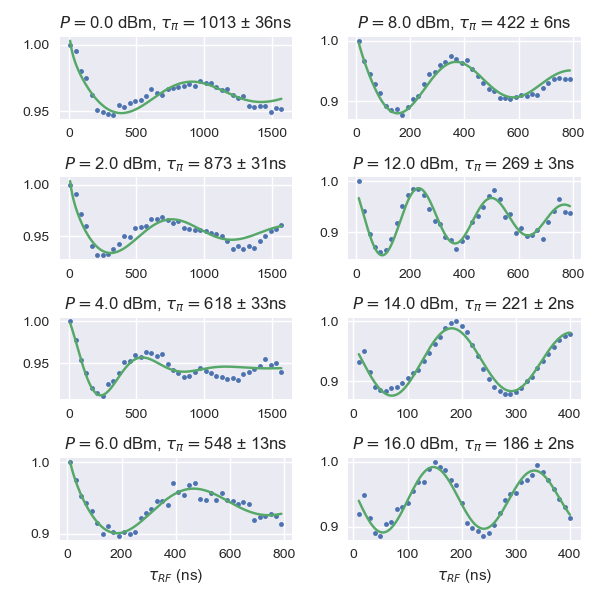

In [4]:
%matplotlib widget

keys_to_plot = ['20220208-1453-21', '20220208-1600-40', '20220208-1623-58', '20220208-1629-50', '20220208-1641-00', '20220208-1647-50', '20220208-1921-36', '20220208-1932-34']
fig, ax = plt.subplots(nrows=len(keys_to_plot) // 2, ncols=len(keys_to_plot)//4, sharex=False, figsize=(6, 6))

frequencies, powers = [], []

idx = 0
idx2 = 0
for key in keys_to_plot:
    power = rabi[key].get_param_from_filename(unit="dBm")
    
    x, _ =  rabi[key].pulsed_measurement.get_data()
    x *= 1e9

    y, yerr = qft.analyse_mean_norm(rabi[key].laser_pulses.data, signal_start=170e-9, signal_end=250e-9, norm_start=1000e-9, norm_end=2000e-9)
    y /= np.max(y)
        
    ax[idx, idx2].plot(x, y, ".")
    
    if power < 12:
        fit_x, fit_y, result = qft.perform_fit(x, y, "sinestretchedexponentialdecay")
    else:
        fit_x, fit_y, result = qft.perform_fit(x, y, "sineexponentialdecay")

        
    pi_length = 1 / result.params["frequency"].value
    pi_length_err = pi_length * (result.params["frequency"].stderr / result.params["frequency"].value)
        
    powers.append(shp.decibelm_to_watts(power))
    frequencies.append(result.params["frequency"].value)
    
    ax[idx, idx2].plot(fit_x, fit_y)
    ax[idx, idx2].set_title(r"$P=$" + f"{power} dBm, " + r"$\tau_{\pi}=$" + f"{int(pi_length)} ± {int(pi_length_err)}ns ")
    
    if idx == 3:
        ax[idx, idx2].set_xlabel(r"$\tau_{RF}$ (ns)")
        idx2 += 1
        idx = -1
    idx += 1

fig.tight_layout()
#sio.save_figures("rabi_comparison", FIGURE_FOLDERPATH)

In [ ]:
%matplotlib widget

fig, ax = plt.subplots(figsize=(4, 3))
x = np.sqrt(powers) * 1e3
y = np.array(frequencies) * 1e3
ax.plot(x, y, "o")
ax.set_xlabel(r"Power ($\sqrt{mW}$)")
ax.set_ylabel("Rabi frequency (MHz) ")

fit_x, fit_y, result = qft.perform_fit(x, y, "linear")
ax.plot(fit_x, fit_y)

fig.tight_layout()
sio.save_figures("rabi_power_dep", FIGURE_FOLDERPATH)

## Timetrace

In [ ]:
%matplotlib widget

fig, ax = plt.subplots(figsize=(6, 4))

timetrace1 = rabi["20220208-1950-35"]["raw_timetrace"]["data"][1]
timetrace2 = rabi["20220208-1950-35"]["raw_timetrace"]["data"][0]

linewidth = 0.8
ax.plot(timetrace1, linewidth=linewidth, label=r"$N_{|0\rangle}$")
ax.plot(timetrace2, linewidth=linewidth, label=r"$N_{|1\rangle}$")
ax.plot(timetrace1 - timetrace2, linewidth=linewidth, label=r"Signal ($N_{|0\rangle} - N_{|1\rangle}$)")

integration_start = 170
integration_width = 250
ax.axvspan(integration_start, integration_start+integration_width, alpha=0.3, color="C3", linewidth=0, label="Integration window")
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Counts (a.u.)")
ax.axes.yaxis.set_ticklabels([])

ax.legend()
fig.tight_layout()
sio.save_figures("state_timetrace", FIGURE_FOLDERPATH)

## Rabi full analysis

In [ ]:
rabi.keys()

In [ ]:
fig, ax = plt.subplots()

x = rabi["20220208-1641-00"]["pulsed_measurement"]["data"]["Controlled variable(s)"]
y = rabi["20220208-1641-00"]["pulsed_measurement"]["data"]["Signal"]
y /= y.max()

ax.plot(x, y, "o")
fit_x, fit_y, result = qft.perform_fit(x, y, "sineexponentialdecay")
ax.plot(fit_x, fit_y)

In [ ]:
y, yerr = qft.analyse_mean_reference(laser_pulses, signal_start=200e-9, signal_end=350e-9, norm_start=1000e-9, norm_end=1500e-9)
y

## Parameter optimizer

In [ ]:
import itertools

In [ ]:
signal_starts = np.linspace(150e-9, 240e-9, 10)
signal_ends = np.linspace(250e-9, 500e-9, 10)
optimize_parameter_mean = np.zeros(len(signal_starts) * len(signal_ends))
optimize_parameter_mean_norm = np.zeros(len(signal_starts) * len(signal_ends))

for idx, (signal_start, signal_end) in enumerate(itertools.product(signal_starts, signal_ends)):
    y, yerr = qft.analyse_mean_norm(laser_pulses, signal_start=signal_start, signal_end=signal_end, norm_start=1000e-9, norm_end=2000e-9)
    y /= y.max()
    
    try:
        fit_x, fit_y, result = qft.perform_fit(x, y, "sinestretchedexponentialdecay")
        optimize_parameter_mean_norm[idx] = 1 / (result.params["frequency"].stderr * np.min(y))
    except OverflowError:
        pass
    
    y, yerr = qft.analyse_mean(laser_pulses, signal_start=signal_start, signal_end=signal_start)
    y /= y.max()
    try:
        fit_x, fit_y, result = qft.perform_fit(x, y, "sinestretchedexponentialdecay")
        optimize_parameter_mean[idx] = 1 / (result.params["frequency"].stderr * np.min(y))
    except OverflowError:
        pass

In [ ]:
for idx, (signal_start, signal_end) in enumerate(itertools.product(signal_starts, signal_ends)):
    if idx == np.argmax(optimize_parameter_mean):
        print("Mean", signal_start, signal_end)    
    if idx == np.argmax(optimize_parameter_mean_norm):
        print("Mean norm", signal_start, signal_end)

In [ ]:
laser_pulses = rabi["20220208-1641-00"]["laser_pulses"]["data"]
x = rabi["20220208-1641-00"]["pulsed_measurement"]["data"]["Controlled variable(s)"] * 1e6

fig, ax = plt.subplots(nrows=1, ncols=3, sharey=False)

y, yerr = qft.analyse_mean_norm(laser_pulses, signal_start=170e-9, signal_end=250e-9, norm_start=1000e-9, norm_end=2000e-9)
y /= y.max()

ax[0].plot(x, y, "o")
fit_x, fit_y, result = qft.perform_fit(x, y, "sinestretchedexponentialdecay")
ax[0].plot(fit_x, fit_y)
ax[0].set_title("Mean Norm")
print(result.params["frequency"])

y, yerr = qft.analyse_mean_reference(laser_pulses, signal_start=170e-9, signal_end=250e-9, norm_start=1000e-9, norm_end=2000e-9)
y /= y.max()
ax[1].plot(x, y, "o")
fit_x, fit_y, result = qft.perform_fit(x, y, "sinestretchedexponentialdecay")
ax[1].plot(fit_x, fit_y)
ax[1].set_title("Mean Ref")
print(result.params["frequency"])

y, yerr = qft.analyse_mean(laser_pulses, signal_start=150e-9, signal_end=250e-9)
y /= y.max()
ax[2].plot(x, y, "o")
fit_x, fit_y, result = qft.perform_fit(x, y, "sinestretchedexponentialdecay")
ax[2].plot(fit_x, fit_y)
ax[2].set_title("Mean")
print(result.params["frequency"])

# Ramsey

In [ ]:
ramsey = sio.read_pulsed_measurement_data(DATA_FOLDERPATH, measurement_str="Ramsey")

In [ ]:
qft.get_fits()

In [ ]:
key = "20220203-2258-31"
laser_pulses = ramsey[key]["laser_pulses"]["data"]

In [ ]:
fig, ax = plt.subplots()

ax.plot(laser_pulses[1::2].sum(axis=0))
ax.plot(laser_pulses[::2].sum(axis=0))

ax.plot(laser_pulses[1::2].sum(axis=0) - laser_pulses[::2].sum(axis=0))
ax.axvline(200)
ax.axvline(350)

In [ ]:
x = ramsey[key]["pulsed_measurement"]["data"]["Controlled variable(s)"] * 1e6

y1, yerr1 = qft.analyse_mean_reference(laser_pulses[1::2], signal_start=170e-9, signal_end=250e-9, norm_start=1000e-9, norm_end=1500e-9)
y2, yerr2 = qft.analyse_mean_reference(laser_pulses[::2], signal_start=170e-9, signal_end=250e-9, norm_start=1000e-9, norm_end=1500e-9)

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 8))

ax[0, 0].set_title("Mean Ref")
ax[0, 0].plot(x, y1, "o-")
ax[0, 0].plot(x, y2, "o-")

delta = y1 - y2
ax[1, 0].plot(x, delta, "o-")
fit_x, fit_y, result = qft.perform_fit(x, delta, "sineexponentialdecay")
ax[1, 0].plot(fit_x, fit_y, "-", label=r"$T_2^∗ \approx $" + f"{int(result.params['lifetime'].value)} μs")
ax[1, 0].legend()

# print(result.params["s1_frequency"], result.params["s1_amplitude"], result.params["s2_frequency"], result.params["s2_amplitude"])

y1, yerr1 = qft.analyse_mean(laser_pulses[1::2], signal_start=170e-9, signal_end=250e-9)
y2, yerr2 = qft.analyse_mean(laser_pulses[::2], signal_start=170e-9, signal_end=250e-9)

ax[0, 1].set_title("Mean")
ax[0, 1].plot(x, y1, "o-")
ax[0, 1].plot(x, y2, "o-")

delta = y1 - y2
ax[1, 1].plot(x, delta, "o-")
fit_x, fit_y, result = qft.perform_fit(x, delta, "sineexponentialdecay")
ax[1, 1].plot(fit_x, fit_y, "-", label=r"$T_2^∗ \approx $" + f"{int(result.params['lifetime'].value)} μs")
ax[1, 1].legend()


y1, yerr1 = qft.analyse_mean_norm(laser_pulses[1::2], signal_start=170e-9, signal_end=250e-9, norm_start=1000e-9, norm_end=1500e-9)
y2, yerr2 = qft.analyse_mean_norm(laser_pulses[::2], signal_start=170e-9, signal_end=250e-9,  norm_start=1000e-9, norm_end=1500e-9)

ax[0, 2].set_title("Mean Norm.")
ax[0, 2].plot(x, y1, "o-")
ax[0, 2].plot(x, y2, "o-")

delta = y1 - y2
ax[1, 2].plot(x, delta, "o-")
fit_x, fit_y, result = qft.perform_fit(x, delta, "sineexponentialdecay")
ax[1, 2].plot(fit_x, fit_y, "-", label=r"$T_2^∗ \approx $" + f"{int(result.params['lifetime'].value)} μs")
ax[1, 2].legend()

# print(result.params["s1_frequency"], result.params["s1_amplitude"], result.params["s2_frequency"], result.params["s2_amplitude"])

In [ ]:
key = "20220203-2258-31"

fig, (ax, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 5))
x = ramsey[key]["pulsed_measurement"]["data"]["Controlled variable(s)"] * 1e6

laser_pulses = ramsey[key]["laser_pulses"]["data"]
y1, yerr1= qft.analyse_mean_norm(laser_pulses[::2], signal_start=170e-9, signal_end=250e-9,  norm_start=1000e-9, norm_end=1500e-9)
y2, yerr2 = qft.analyse_mean_norm(laser_pulses[1::2], signal_start=170e-9, signal_end=250e-9, norm_start=1000e-9, norm_end=1500e-9)

ax.plot(x, y1, "o-", label=r"$P\left(\frac{\pi}{2}\right)$")
ax.plot(x, y2, "o-", label=r"$P\left(\frac{3\pi}{2}\right)$")
ax.legend()

delta = y1 - y2
ax1.plot(x, delta, "o-")

fit_x, fit_y, result = qft.perform_fit(x, delta, "sineexponentialdecay")
ax1.plot(fit_x, fit_y, "-", label=r"$T_2^∗ \approx $" + f"{int(result.params['lifetime'].value)} μs")
ax1.legend()
ax1.set_ylabel(r"$\Delta \left(\frac{\pi}{2} - \frac{3\pi}{2}\right)$")
ax1.set_xlabel(r"$\tau$ ($\mu$s)")

sio.save_figures(ramsey[key]["pulsed_measurement"]["filename"], FIGURE_FOLDERPATH)

In [ ]:
string = "ramsey_100dBm.txt"
unit = "dBm"

float(re.findall("([0-9]+)" + f"{unit}", string)[0])

In [ ]:
from PIL import Image

In [ ]:
Image(rab1[""])